In [1]:
!pip install deeptime

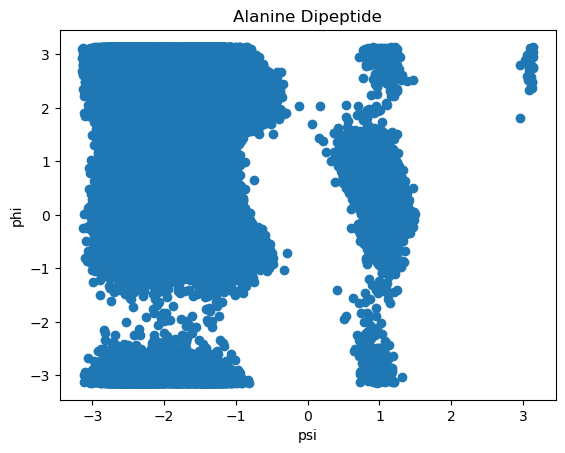

In [3]:
# Let's use deeptime package to try out ADP for illustration

import numpy as np
import matplotlib.pyplot as plt

# load data
features = np.load('/project/dinner/zpengmei/Geom2Vec/Tutorial/adp/adp_gnn_feat.npz')['features']

# load canonical psi-phi features
psi_phi = np.load('/project/dinner/zpengmei/Geom2Vec/Tutorial/adp/alanine-dipeptide-3x250ns-backbone-dihedrals.npz')['arr_0']
psi = psi_phi[:, 0]
phi = psi_phi[:, 1]

# visualize the data
plt.scatter(psi, phi)
plt.xlabel('psi')
plt.ylabel('phi')
plt.title('Alanine Dipeptide')
plt.show()



In [4]:
# Start with something simple as TICA

from deeptime.decomposition import TICA

tica = TICA(lagtime=100, dim=2) # lagtime 100 steps, 2D projection
tica.fit(features)
tica_features = tica.transform(features)

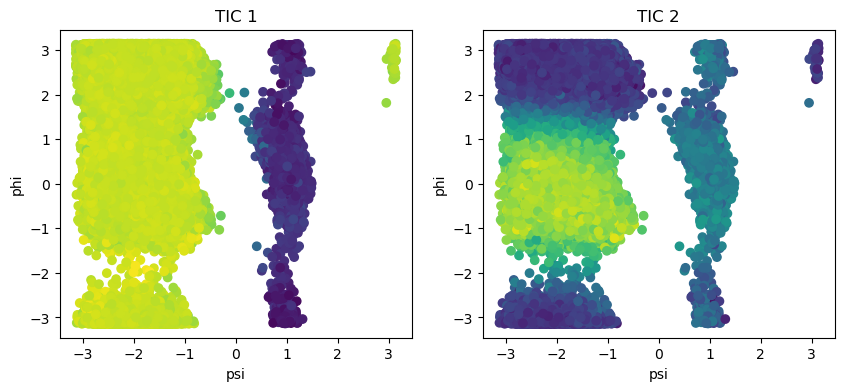

In [6]:
# visualize the data on the psi-phi plane

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(psi, phi, c=tica_features[:, 0])
ax[0].set_xlabel('psi')
ax[0].set_ylabel('phi')
ax[0].set_title('TIC 1')
ax[1].scatter(psi, phi, c=tica_features[:, 1])
ax[1].set_xlabel('psi')
ax[1].set_ylabel('phi')
ax[1].set_title('TIC 2')
plt.show()

In [9]:
# all right, that's linear method, let's try out nonlinear method like VAMPNets
# import vampnet and dataset class
from deeptime.decomposition.deep import VAMPNet
from deeptime.util.data import TrajectoryDataset
import torch

# create dataset
dataset = TrajectoryDataset(100, features.astype(np.float32))

# split the dataset into training and validation
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In [11]:
# a simple MLP VAMP head

import torch.nn as nn
import torch.nn.functional as F

class VAMPHead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(VAMPHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
from tqdm import tqdm
from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=512, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = VAMPHead(256, 2, 64) # 256 input features, 2 output features, 64 hidden units
lobe_lagged = VAMPHead(256, 2, 64) # 256 input features, 2 output features, 64 hidden units

# create VAMPNet
device = ('cuda' if torch.cuda.is_available() else 'cpu')
lobe.to(device)
lobe_lagged.to(device)

vampnet = VAMPNet(lobe=lobe,lobe_timelagged=lobe_lagged, learning_rate=1e-4, device=device)
model = vampnet.fit(loader_train, n_epochs=3,validation_loader=loader_val, progress=tqdm).fetch_model()

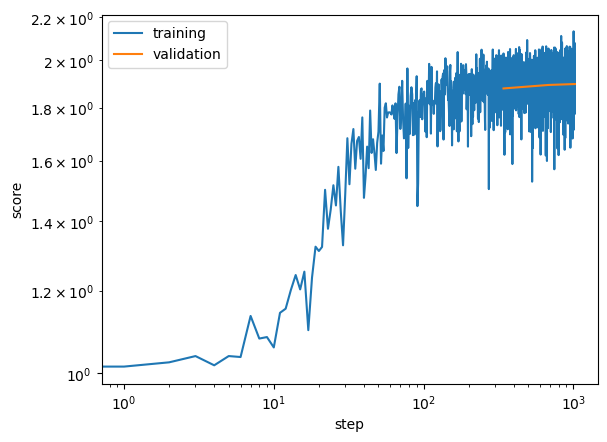

In [19]:
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()

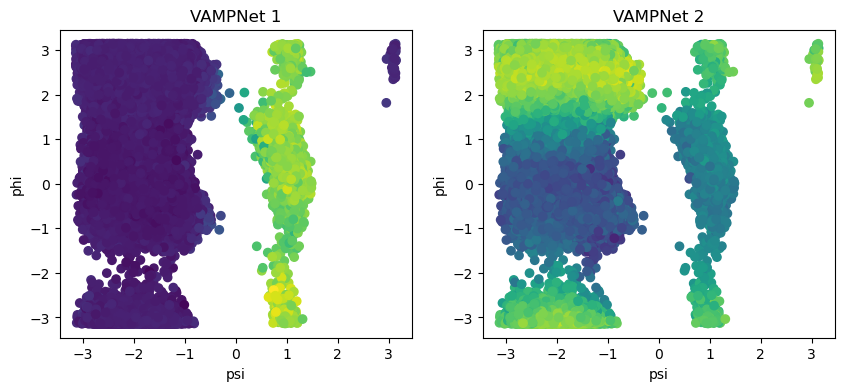

In [24]:
vamp_features = model.transform(features.astype(np.float32))

# plot the data on the psi-phi plane
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(psi, phi, c=vamp_features[:, 0])
ax[0].set_xlabel('psi')
ax[0].set_ylabel('phi')
ax[0].set_title('VAMPNet 1')
ax[1].scatter(psi, phi, c=vamp_features[:, 1])
ax[1].set_xlabel('psi')
ax[1].set_ylabel('phi')
ax[1].set_title('VAMPNet 2')
plt.show()
